<a href="https://colab.research.google.com/github/madrigaljose/madrigaljose/blob/main/20210709_Madrigal_DLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# for data input and output:
import numpy as np
import os
import pandas as pd

# for deep learning: 
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout
from keras.layers import BatchNormalization, Flatten
from keras.layers import Activation
from keras.layers import Reshape # new! 
from keras.layers import Conv2DTranspose, UpSampling2D # new! 
from keras.optimizers import RMSprop # new! 

# for plotting: 
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


#################
import tensorflow as tf
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#Reading CSV Data from my github, also, parsing and indexing the first column as dates for later data merging, removing and cleaning spaces
#from column names for future data prep
#github url = 'https://raw.githubusercontent.com/madrigaljose/madrigaljose/main/koyfin_Deere.csv'
#header list below will be used for all 5 csv files for consistent naming
#header_list=['Open','Low','High','Close','SMA50D','SMA200D']
#nulls will be dropped
#DE = pd.read_csv('https://raw.githubusercontent.com/madrigaljose/madrigaljose/main/koyfin_Deere.csv',parse_dates=[' Date'],index_col=' Date',thousands=',')#,dtype=np.float64)
#DE=DE.set_axis(['Open','Low','High','DE_Close','SMA50D','SMA200D'], axis='columns').rename_axis('Date')
#DE=DE.dropna()

In [3]:
!pip install pandas-datareader
!pip install yfinance --upgrade --no-cache-dir
import pandas_datareader.data as pdr
import yfinance as yf


     |████████████████████████████████| 6.3 MB 11.5 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=d959817a4b08a1cf3f40986173fb4db311eff1d4e4318ab11dfd0a000c02f065
  Stored in directory: /tmp/pip-ephem-wheel-cache-r45o6byi/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
yf.pdr_override()
DE = pdr.get_data_yahoo('DE')#, start, end)
DE['DE_Close'] = DE[['Adj Close']]  
DE=DE[['DE_Close']]

[*********************100%***********************]  1 of 1 completed


In [35]:
#same code will be used below for reading 3 additional files
Corn = pd.read_csv('https://raw.githubusercontent.com/madrigaljose/madrigaljose/main/koyfin_Corn.csv',parse_dates=[' Date'],index_col=' Date',thousands=',')
Corn=Corn.set_axis(['Corn_Input','Low','High','Close','SMA50D','SMA200D'], axis='columns').rename_axis('Date')
Corn=Corn.dropna()
Cotton = pd.read_csv('https://raw.githubusercontent.com/madrigaljose/madrigaljose/main/koyfin_Cotton.csv',parse_dates=[' Date'],index_col=' Date',thousands=',')
Cotton=Cotton.set_axis(['Cotton_Input','Low','High','Close','SMA50D','SMA200D'], axis='columns').rename_axis('Date')
Cotton=Cotton.dropna()
Wheat = pd.read_csv('https://raw.githubusercontent.com/madrigaljose/madrigaljose/main/koyfin_Wheat.csv',parse_dates=[' Date'],index_col=' Date',thousands=',')
Wheat=Wheat.set_axis(['Wheat_Input','Low','High','Close','SMA50D','SMA200D'], axis='columns').rename_axis('Date')
Wheat=Wheat.dropna()
Soy = pd.read_csv('https://raw.githubusercontent.com/madrigaljose/madrigaljose/main/koyfin_Soy.csv',parse_dates=[' Date'],index_col=' Date',thousands=',')
Soy=Soy.set_axis(['Soy_Input','Low','High','Close','SMA50D','SMA200D'], axis='columns').rename_axis('Date')
Soy=Soy.dropna()


In [36]:
#Inspecting the 5 data frames
#DE.info()
#DE
#Corn.info()
#Corn
#Cotton.info()
#Cotton
Soy.info()
Soy
#Wheat.info()
#Wheat

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10859 entries, 1978-07-07 to 2021-06-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Soy_Input  10859 non-null  float64
 1   Low        10859 non-null  float64
 2   High       10859 non-null  float64
 3   Close      10859 non-null  float64
 4   SMA50D     10859 non-null  float64
 5   SMA200D    10859 non-null  float64
dtypes: float64(6)
memory usage: 593.9 KB


,Soy_Input,Low,High,Close,SMA50D,SMA200D
Date,,,,,,
1978-07-07,695.4,691.00,700.40,696.40,704.68,627.43
1978-07-10,700.2,694.00,702.00,696.20,704.48,628.18
1978-07-11,694.6,684.00,695.00,687.20,703.79,628.86
1978-07-12,683.4,679.00,686.00,683.40,702.79,629.60
1978-07-13,679.6,667.00,680.00,668.20,701.74,630.31
...,...,...,...,...,...,...
2021-06-21,1374.0,1370.00,1422.50,1415.00,1527.79,1317.52
2021-06-22,1420.0,1393.25,1427.25,1394.50,1527.89,1319.39
2021-06-23,1392.0,1381.00,1406.75,1385.00,1527.39,1321.36


Initial Model will try to predict the Deere stock **(DE)** Closing price based on the opening values of the main 4 agricultural commodities **(Corn, Cotton, Soy, Wheat)**

In [37]:
DE_df=DE
#DE_df=DE_df.drop(columns=['Low','High','Open','SMA50D','SMA200D'])


In [38]:
######Use below for commodities Open price
#Corn_df=Corn
#Corn_df=Corn_df.drop(columns=['Low','High','Close','SMA50D','SMA200D'])
#Cotton_df=Cotton
#Cotton_df=Cotton_df.drop(columns=['Low','High','Close','SMA50D','SMA200D'])
#Soy_df=Soy
#Soy_df=Soy_df.drop(columns=['Low','High','Close','SMA50D','SMA200D'])
#Wheat_df=Wheat
#Wheat_df=Wheat_df.drop(columns=['Low','High','Close','SMA50D','SMA200D'])
###############################Use below for SMA200D
Corn_df= Corn[['SMA200D']].rename(columns={"SMA200D":"Corn_Input"})
Soy_df= Soy[['SMA200D']].rename(columns={"SMA200D":"Soy_Input"})
Wheat_df= Wheat[['SMA200D']].rename(columns={"SMA200D":"Wheat_Input"})
Cotton_df= Cotton[['SMA200D']].rename(columns={"SMA200D":"Cotton_Input"})

In [39]:
Corn_df.tail()

,Corn_Input
Date,
2021-06-21,522.12
2021-06-22,523.59
2021-06-23,525.13
2021-06-24,526.56
2021-06-25,528.00


In [40]:
df1=Corn_df.join(Cotton_df, how='inner').join(Soy_df, how='inner').join(Wheat_df, how='inner').join(DE_df, how='inner')
df1.info()
df1

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10304 entries, 1978-07-07 to 2021-06-24
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Corn_Input    10304 non-null  float64
 1   Cotton_Input  10304 non-null  float64
 2   Soy_Input     10304 non-null  float64
 3   Wheat_Input   10304 non-null  float64
 4   DE_Close      10304 non-null  float64
dtypes: float64(5)
memory usage: 483.0 KB


,Corn_Input,Cotton_Input,Soy_Input,Wheat_Input,DE_Close
Date,,,,,
1978-07-07,234.18,284.63,627.43,57.28,1.709103
1978-07-10,234.37,284.99,628.18,57.33,1.729369
1978-07-11,234.54,285.34,628.86,57.36,1.769900
1978-07-12,234.69,285.65,629.60,57.41,1.749635
1978-07-13,234.85,285.96,630.31,57.46,1.756390
...,...,...,...,...,...
2021-06-18,520.61,634.91,1315.47,78.03,328.123810
2021-06-21,522.12,635.59,1317.52,78.13,337.010895
2021-06-22,523.59,636.28,1319.39,78.23,341.220032


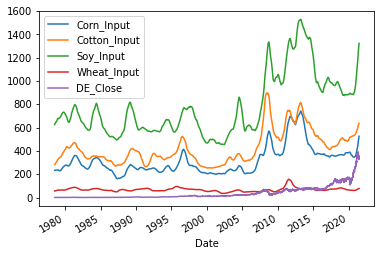

In [41]:
df1.plot()
plt.show()

In [42]:
#importing necessary libraries

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error


In [43]:
dataset=df1
#scale the values
dataset = dataset.values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

#divide the data into train and test data
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

#index the data into dependent and independent variables
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

#convert data into suitable dimension for using it as input in LSTM network
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8243, 4) (8243,) (2061, 4) (2061,)
(8243, 1, 4) (8243,) (2061, 1, 4) (2061,)


Epoch 1/50
65/65 - 3s - loss: 0.0337 - val_loss: 0.2672
Epoch 2/50
65/65 - 0s - loss: 0.0481 - val_loss: 0.2552
Epoch 3/50
65/65 - 0s - loss: 0.0438 - val_loss: 0.2435
Epoch 4/50
65/65 - 0s - loss: 0.0412 - val_loss: 0.2370
Epoch 5/50
65/65 - 0s - loss: 0.0359 - val_loss: 0.2259
Epoch 6/50
65/65 - 0s - loss: 0.0344 - val_loss: 0.2225
Epoch 7/50
65/65 - 0s - loss: 0.0329 - val_loss: 0.2196
Epoch 8/50
65/65 - 0s - loss: 0.0325 - val_loss: 0.2195
Epoch 9/50
65/65 - 0s - loss: 0.0331 - val_loss: 0.2210
Epoch 10/50
65/65 - 0s - loss: 0.0326 - val_loss: 0.2202
Epoch 11/50
65/65 - 0s - loss: 0.0323 - val_loss: 0.2202
Epoch 12/50
65/65 - 0s - loss: 0.0312 - val_loss: 0.2191
Epoch 13/50
65/65 - 0s - loss: 0.0314 - val_loss: 0.2195
Epoch 14/50
65/65 - 0s - loss: 0.0315 - val_loss: 0.2208
Epoch 15/50
65/65 - 0s - loss: 0.0308 - val_loss: 0.2199
Epoch 16/50
65/65 - 0s - loss: 0.0299 - val_loss: 0.2193
Epoch 17/50
65/65 - 0s - loss: 0.0307 - val_loss: 0.2204
Epoch 18/50
65/65 - 0s - loss: 0.0306 - 

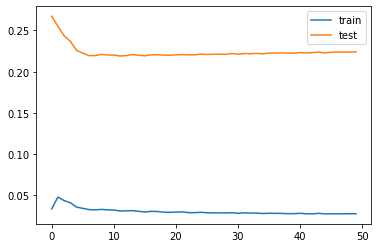

In [44]:
model = Sequential()
model.add(LSTM(16, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.05))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=50, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
#32,0.2,72
#32,0.05,256 --> Good
#32,0.1,256 --> 
#32,0.1,512 --> 


In [45]:
combined_df=df1
combined_df.describe()
#combined_df.to_csv("data2/group_project.csv")

,Corn_Input,Cotton_Input,Soy_Input,Wheat_Input,DE_Close
count,10304.000000,10304.000000,10304.000000,10304.000000,10304.000000
mean,314.756408,422.134616,771.444415,68.677713,37.480363
std,117.449086,137.965343,255.580212,16.395537,56.790942
min,161.610000,253.250000,454.650000,35.440000,1.453617
25%,236.042500,327.950000,581.690000,59.210000,3.524290
50%,272.825000,375.915000,685.350000,66.085000,12.992323
75%,366.312500,492.600000,913.247500,75.662500,59.246207
max,742.470000,898.530000,1528.590000,157.570000,393.205963


done


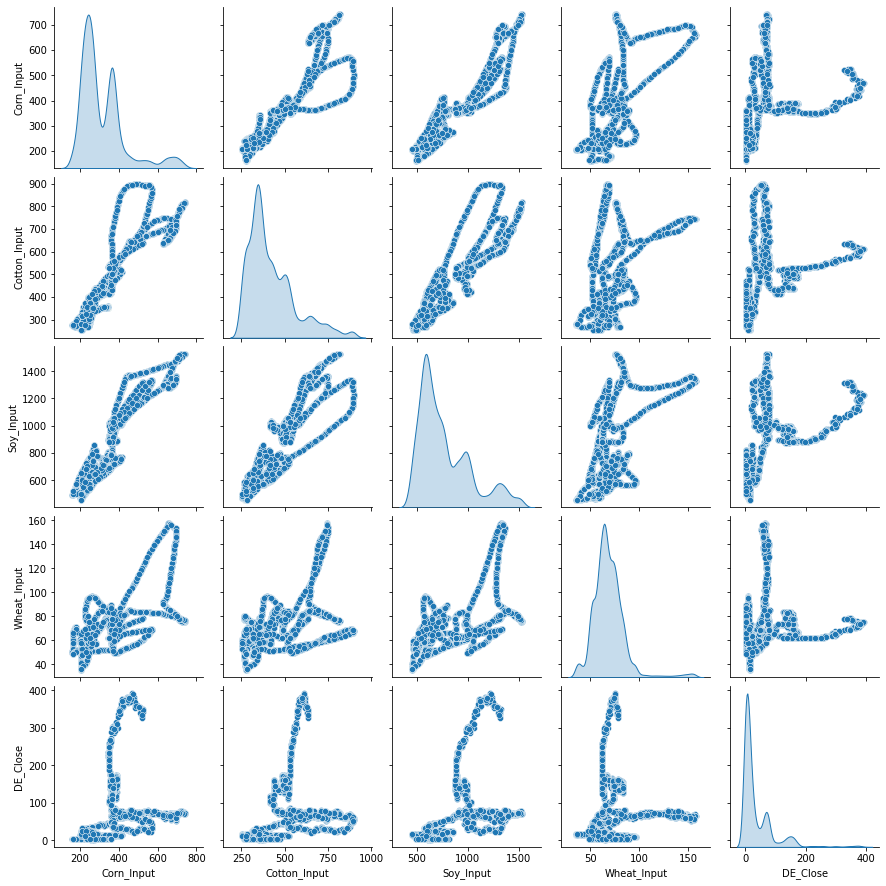

In [47]:
train_dataset = combined_df.sample(frac=0.8,random_state=0)
test_dataset = combined_df.drop(train_dataset.index)
print("done")
sns.pairplot(train_dataset[['Corn_Input','Cotton_Input','Soy_Input','Wheat_Input','DE_Close']], diag_kind="kde")
plt.show()

In [48]:
train_labels = train_dataset.pop('DE_Close')
test_labels = test_dataset.pop('DE_Close')
print("done")

done


In [49]:
inputs = len(train_dataset.keys())
print("number of inputs to the model = " + str(inputs))

def build_model():
  model = keras.Sequential([
    #input_shape=(9,),
    layers.Dense(64, activation=tf.nn.relu,input_shape=([len(train_dataset.keys())]),),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model
  print("done")

number of inputs to the model = 4


In [50]:
model = build_model()
print("done")

done


In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [53]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,234.110382,7.950578,234.110382,244.407059,8.022005,244.407059,995
996,232.517181,7.953521,232.517181,226.573608,7.890307,226.573608,996
997,255.497086,8.168362,255.497086,222.354248,7.971249,222.354248,997
998,244.919250,8.187074,244.919250,226.480209,7.908562,226.480209,998
999,219.493637,7.912444,219.493637,396.003967,12.672560,396.003967,999


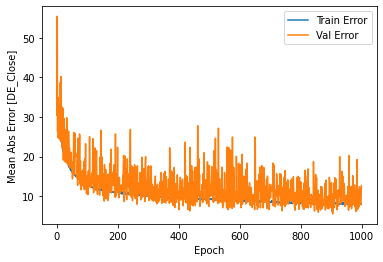

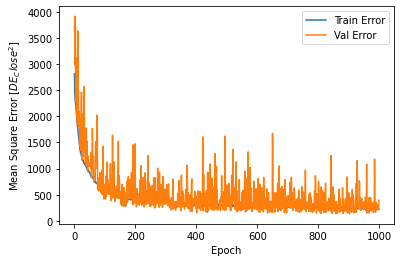

In [54]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [DE_Close]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  #plt.ylim([0,10])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$DE_Close^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,200])
  plt.legend()
  plt.show()


plot_history(history)


....................................................................................................
....................................................................................................
..........................................................

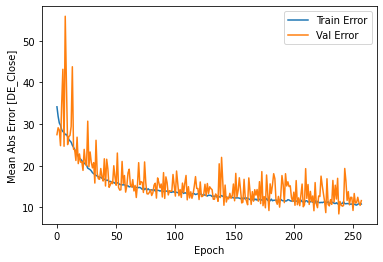

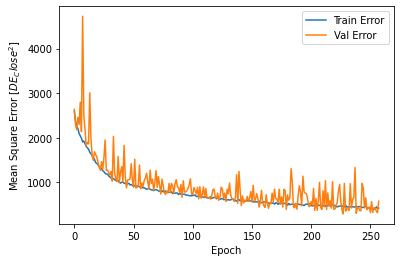

In [55]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

history = model.fit(train_dataset, train_labels, epochs=EPOCHS,
                    validation_split = 0.3, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [56]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} $".format(mae))

Testing set Mean Abs Error: 11.35 $


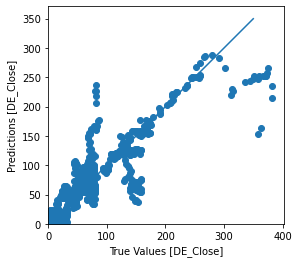

In [73]:
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DE_Close]')
plt.ylabel('Predictions [DE_Close]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-400, 350], [-400, 350])
plt.show()

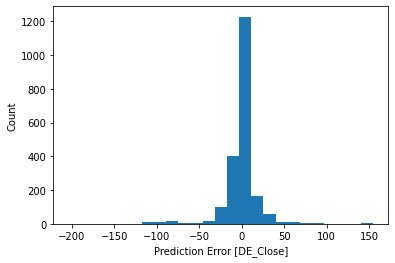

In [74]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [DE_Close]")
_ = plt.ylabel("Count")
plt.show()

In [67]:
model_prediction = combined_df.sample()
trial=(model_prediction[['Corn_Input','Cotton_Input','Soy_Input','Wheat_Input']],)
trial_predictions = model.predict(trial).flatten()
print("done")
print("Prediction:",trial_predictions,"Real:",model_prediction.iloc[0]["DE_Close"])

done
Prediction: [83.93552] Real: 73.02989196777344


Reference Code

In [ ]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} $".format(mae))

Testing set Mean Abs Error:  3.58 $


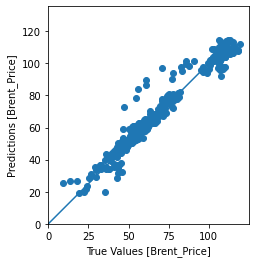

In [ ]:
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Brent_Price]')
plt.ylabel('Predictions [Brent_Price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

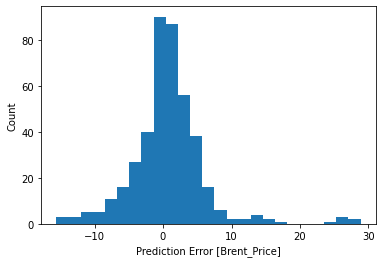

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Brent_Price]")
_ = plt.ylabel("Count")
plt.show()

In [ ]:
model_prediction = combined_df.sample()
trial=(model_prediction[["XOM","CVX","EOG","PSX","COP"]],)
trial_predictions = model.predict(trial).flatten()
print("done")
print("Prediction:",trial_predictions,"Real:",model_prediction.iloc[0]["Brent_Price"])

done
Prediction: [33.53655] Real: 30.94


In [ ]:
#Normalized data
#XOM,CVX,EOG,PSX,COP,Brent_Price
#trial=([40.420000,85.250000,43.685000,60.924999,38.239999],) #	45.79
#trial_predictions = model.predict(trial).flatten()
#print("done")
#print("Prediction:",trial_predictions,"Real:","Check Todays Rate")

In [ ]:

GCCOOP = pd.read_csv('https://www.gccoop.com/GardenCity/media/Content/Grain%20Price%20History%20CSV%20files/2001-Grain-Bids.csv')

In [ ]:
GCCOOP

,Unnamed: 0,"Garden City Co-op, Inc.",Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,NaN,2001 Grain Bids,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,Old Crop,Old Crop,Old Crop,Old Crop,New Crop,New Crop,New Crop,New Crop,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,Date,Wheat,Milo,Corn,Beans,Wheat,Milo,Corn,Beans,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1/2/01,$2.86,$3.56,$2.17,$4.58,$2.92,$3.65,$2.35,$4.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,NaN,12/21/01,$2.53,$3.15,$2.12,$3.90,$2.41,$3.42,$2.26,$3.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN
348,NaN,12/26/01,$2.52,$3.09,$2.10,$3.82,$2.40,$3.38,$2.25,$3.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN
349,NaN,12/27/01,$2.55,$3.11,$2.12,$3.82,$2.43,$3.39,$2.25,$3.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350,NaN,12/28/01,$2.59,$3.11,$2.12,$3.79,$2.44,$3.40,$2.26,$3.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
GCCOOP

<bound method DataFrame.dropna of     Unnamed: 0 Garden City Co-op, Inc.  ... Unnamed: 15 Unnamed: 16
0          NaN         2000 Grain Bids  ...         NaN         NaN
1          NaN                     NaN  ...         NaN         NaN
2          NaN                     NaN  ...                     NaN
3                                 Date  ...                     NaN
4          NaN                  1/3/00  ...                     NaN
..         ...                     ...  ...         ...         ...
350        NaN                12/22/00  ...         NaN         NaN
351        NaN                12/26/00  ...         NaN         NaN
352        NaN                12/27/00  ...         NaN         NaN
353        NaN                12/28/00  ...         NaN         NaN
354        NaN                12/29/00  ...         NaN         NaN

[355 rows x 17 columns]>